<img src="img/Marca-ITBA-Color-ALTA.png" width="250">

# Programación para el Análisis de Datos

## Clase 4 parte 1 - Agrupaciones y agregaciones con Pandas

#### Referencias y bibliografía de consulta:

- Python for Data Analysis by Wes McKinney (O’Reilly) 2022 - capítulo 10

- https://pandas.pydata.org/

### Introducción

En la sección anterior se realizó una introducción a la transformación de datos utilizando funciones como `map`, `apply`, y `applymap`. Estas funciones son una de las piedras fundamentales en el análisis de datos.

Ahora se explorarán funciones que se utilizan para agrupar datos y realizar agregaciones con diferentes funciones y operaciones matemáticas.
La agrupación de datos se utiliza para ordenar y clasificar datos según un valor o categoría.

Después de cargar, fusionar y preparar un conjunto de datos, puede que sea necesario calcular estadísticas de grupo o tablas pivot para reportes y/o visualización.

El módulo `Pandas` provee métodos que nos permiten realizar estas tareas de forma natural.


- Dividir un objeto `Pandas` en partes usando una o más claves.

- Calcular estadísticos sobre grupos, como la media, el desvío estandar, o cualquier función definida por el usuario.

- Aplicar transformaciones por grupos.

- Construir tablas pivot.

In [1]:
import numpy as np
import pandas as pd

Para empezar, importamos el dataset que utilizaremos a modo de ejemplo.
En la clase de hoy vamos a usar un dataset sobre datos de una compañía telefónica. Este dataset contiene la siguiente información
- **date**: Fecha y hora del evento. Formato 'DD/MM/YY HH:mm'
- **duration**: Duración en segundos de cada llamada, la cantidad de datos (en MB) enviados y la cantidad de mensajes de texto enviados.
- **item**: Descripción del evento. Puede ser uno de los 3 grupos: Llamada (call), SMS (sms) o GPRS (data)
- **month**: Mes de facturación al que corresponde el evento. Formato 'YYYY-MM'
- **network**: Red movil utilizada por el evento.
- **network_type**: Tipo de servicio utilizado. Llamada local a celular (mobile), llamada a teléfono fijo (landline), internacional (world), buzón de voz (voicemail), envio de datos (data) u otros (special).



Investiguemos el dataset!

In [2]:
dataset = pd.read_csv('data/phone_data.csv', index_col=0)

dataset.head()

,date,duration,item,month,network,network_type
index,,,,,,
0,15/10/14 06:58,34.429,data,2014-11,data,data
1,15/10/14 06:58,13.000,call,2014-11,Vodafone,mobile
2,15/10/14 14:46,23.000,call,2014-11,Meteor,mobile
3,15/10/14 14:48,4.000,call,2014-11,Tesco,mobile
4,15/10/14 17:27,4.000,call,2014-11,Tesco,mobile


In [3]:
dataset.shape

(830, 6)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 829
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          830 non-null    object 
 1   duration      830 non-null    float64
 2   item          830 non-null    object 
 3   month         830 non-null    object 
 4   network       830 non-null    object 
 5   network_type  830 non-null    object 
dtypes: float64(1), object(5)
memory usage: 45.4+ KB


In [5]:
dataset['item'].unique()

array(['data', 'call', 'sms'], dtype=object)

Vemos que la *feature* `date` está casteada como object. Vamos a Transformarlo en datetime. 

In [6]:
dataset['date'] = pd.to_datetime(dataset['date'], format='%d/%m/%y %H:%M')

Tomemos una muestra de 3 elementos para ver cómo podemos trabajar con los datetime de `Pandas`:

In [7]:
head_date = dataset.head(3)['date']
head_date

index
0   2014-10-15 06:58:00
1   2014-10-15 06:58:00
2   2014-10-15 14:46:00
Name: date, dtype: datetime64[ns]

In [8]:
print(f"days:\n{head_date.dt.day}\n")
print(f"months:\n{head_date.dt.month}\n")
print(f"years:\n{head_date.dt.year}\n")

days:
index
0    15
1    15
2    15
Name: date, dtype: int32

months:
index
0    10
1    10
2    10
Name: date, dtype: int32

years:
index
0    2014
1    2014
2    2014
Name: date, dtype: int32



### Exploración de los datos

* ¿Qué período de tiempo abarca el dataset?

* ¿En qué meses hubo más facturación?

In [9]:
start = dataset['date'].min()
end = dataset['date'].max()

print(f"Período: {start.date()} - {end.date()}")

Período: 2014-10-15 - 2015-03-14


In [10]:
print("Cantidad de observaciones por mes")

dataset['date'].dt.month.value_counts().sort_index()

Cantidad de observaciones por mes


date
1     169
2     118
3      39
10    111
11    227
12    166
Name: count, dtype: int64

- Cuál es la duración máxima de las llamadas?

In [11]:
d_max = dataset[dataset['item'] =='call']['duration'].max()
print(f"La duración máxima de una llamada fue de {d_max} segundos")

La duración máxima de una llamada fue de 10528.0 segundos


- A qué llamada corresponde?

In [12]:
dataset[dataset['duration'] == d_max]

,date,duration,item,month,network,network_type
index,,,,,,
816,2015-03-04 12:29:00,10528.0,call,2015-03,landline,landline


Vamos a crear una variable categorica que divida los eventos de llamadas según la duración (mayor igual o menor a 117seg)

In [13]:
mask = (dataset['item'] == 'call') & (dataset['duration'] < 117)
dataset.loc[mask, 'key_bin'] = 'D0'
dataset.loc[~ mask, 'key_bin'] = 'D1'

In [14]:
dataset.sample(10, random_state=1)

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
786,2015-02-28 17:14:00,3.000,call,2015-03,landline,landline,D0
522,2015-01-05 10:52:00,1.000,sms,2015-01,Three,mobile,D1
811,2015-03-04 06:58:00,34.429,data,2015-03,data,data,D1
579,2015-01-13 19:09:00,1.000,sms,2015-01,Three,mobile,D1
573,2015-01-12 12:01:00,7.000,call,2015-01,Meteor,mobile,D0
8,2014-10-16 15:12:00,1050.000,call,2014-11,Three,mobile,D1
457,2014-12-24 13:56:00,3.000,call,2015-01,Three,mobile,D0
364,2014-12-07 13:03:00,99.000,call,2014-12,voicemail,voicemail,D0
610,2015-01-17 06:58:00,34.429,data,2015-02,data,data,D1


Para poder contestar preguntas mas complejas, se define el concepto de agrupación por clave, o **group by**.

Pandas implementa un método especial para este tipo de tareas.

## GroupBy

Podemos describir las operaciones sobre grupos en términos del proceso **split-apply-combine**. 

En la primera etapa del proceso, el **split**, los datos en un objeto `Pandas` (una instancia de `Series` o de `DataFrame`) se dividen en grupos en base a una o más claves. 

Luego, en la fase de **apply**, aplicamos una función a cada uno de los grupos dando como resultado un nuevo valor por grupo.

En el último paso, el **combine**, los resultados de la aplicación de la función en cada uno de los grupos se combinan en un objeto resultado.


<img src="img/split_apply_combine.png" width="450">


El objeto `GroupBy` realiza todo este proceso en un solo paso. 

En el paso de *Apply* se puede necesitar realizar distintas operaciones, como pueden ser:

- Aggregaciones: Aplica una función de reduccion, generalmente estadistica (suma, cantidad, media), para cada uno de los subgrupos
- Transformaciones: Aplicar una transformación específica para cada uno de los subgrupos. (Completar nulos)
- Filtrado: Filtra en función del grupo. (Descartar algunos grupos, eliminar outliers)

Las operaciones de group by se realizan con el objeto **GroupBy**

### El objeto GroupBy



El objeto `GroupBy` es un abstracción muy flexible. Pandas permite utilizar el objeto tanto para `DataFrame` como para `Serie`.

Este objeto **NO** retorna un `DataFrame`, sino un objeto `DataFrameGroupBy`. 

In [15]:
grouped_item = dataset.groupby('item')
grouped_item

Con el atributo `groups` podemos ver cómo repartió a los elementos del `index` en lo diferentes grupos. El atributo groups nos muestra un diccionario cuyas claves son los items y los valores son los índices para cada item.

In [16]:
grouped_item.groups

{'call': [1, 2, 3, 4, 5, 7, 8, 9, 10, 19, 20, 21, 27, 28, 29, 30, 31, 32, 34, 35, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 55, 57, 59, 60, 64, 65, 78, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 98, 99, 100, 104, 105, 106, 109, 110, 112, 113, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129, 130, 136, 137, 139, 140, 141, 146, 147, 150, 152, 156, 162, 163, 164, 165, 166, 168, 169, 171, 172, 183, 184, 190, 191, 193, 194, 195, 196, ...], 'data': [0, 6, 13, 26, 39, 45, 54, 56, 58, 66, 80, 81, 87, 92, 95, 97, 101, 111, 114, 120, 131, 151, 159, 170, 182, 189, 192, 199, 208, 228, 231, 234, 235, 237, 238, 249, 254, 263, 275, 281, 288, 291, 305, 321, 324, 328, 330, 338, 341, 343, 346, 351, 355, 363, 372, 374, 376, 377, 378, 381, 386, 389, 396, 397, 400, 409, 420, 426, 427, 443, 453, 463, 465, 468, 473, 474, 476, 496, 504, 505, 509, 512, 516, 529, 537, 541, 555, 560, 568, 571, 577, 586, 594, 598, 610, 613, 616, 621, 625, 634, ...], 'sms': [11, 12, 14, 15, 16, 17, 18, 22, 23, 24,

In [17]:
grouped_item.groups.keys()

dict_keys(['call', 'data', 'sms'])

In [18]:
grouped_item.groups['call']

Index([  1,   2,   3,   4,   5,   7,   8,   9,  10,  19,
       ...
       801, 802, 803, 805, 806, 807, 808, 809, 810, 816],
      dtype='int64', name='index', length=388)

Se puede pensar en el `DataFrameGroupBy` como una vista especial de un `DataFrame` que construye los grupos pero que no realiza ningún cómputo hasta que la etapa de agregación es aplicada.

Para producir un resultado podemos aplicar una función de agregación a este `DataFrameGroupBy` que a realiza la operación (apply) y avanza en el paso de combine.

Veamos algunos ejemplos:

In [19]:
grouped_item[['duration']].mean()

,duration
item,
call,237.940722
data,34.429000
sms,1.000000


In [20]:
grouped_item['duration'].mean()

item
call    237.940722
data     34.429000
sms       1.000000
Name: duration, dtype: float64

In [21]:
grouped_item[['duration']].std()

,duration
item,
call,628.551264
data,0.000000
sms,0.000000


También se pueden realizar operaciones mas complejas para contestar preguntas cómo.
- Cuál es el promedio de la duración de llamada para cada red utilizada?

In [22]:
dataset.loc[dataset['item'] == 'call'].groupby('network')[['duration']].mean()

,duration
network,
Meteor,133.333333
Tesco,194.760563
Three,284.875000
Vodafone,221.530303
landline,438.880952
voicemail,65.740741


El `GroupBy` también nos permite utilizar más de una clave:

In [23]:
list(dataset.groupby(['month', 'item']).groups.keys())

[('2014-11', 'call'),
 ('2014-11', 'data'),
 ('2014-11', 'sms'),
 ('2014-12', 'call'),
 ('2014-12', 'data'),
 ('2014-12', 'sms'),
 ('2015-01', 'call'),
 ('2015-01', 'data'),
 ('2015-01', 'sms'),
 ('2015-02', 'call'),
 ('2015-02', 'data'),
 ('2015-02', 'sms'),
 ('2015-03', 'call'),
 ('2015-03', 'data'),
 ('2015-03', 'sms')]

Se puede ver que se genera una clave para cada combinación única de ambas columnas.

La cantidad máxima de claves resulta ser $C_1*C_2$, siendo $C_i$ la cardinalidad de la columna $i$

In [24]:
dataset.groupby(['month', 'item'])[['date']].count()

date
month   item      
2014-11 call   107
        data    29
        sms     94
2014-12 call    79
        data    30
        sms     48
2015-01 call    88
        data    31
        sms     86
2015-02 call    67
        data    31
        sms     39
2015-03 call    47
        data    29
        sms     25

In [25]:
dataset.groupby(['month', 'item']).size()

month    item
2014-11  call    107
         data     29
         sms      94
2014-12  call     79
         data     30
         sms      48
2015-01  call     88
         data     31
         sms      86
2015-02  call     67
         data     31
         sms      39
2015-03  call     47
         data     29
         sms      25
dtype: int64

El tipo de dato de salida depende de la cantidad de columnas y como se seleccionen. 
Esto es similar a la selección de columnas dentro de un dataframe.

In [26]:
print("Utilizando [], el tipo de dato es: {}".format(type(dataset.groupby(['month', 'item'])['date'].count())))
print("Utilizando [[]], el tipo de dato es: {}".format(type(dataset.groupby(['month', 'item'])[['date']].count())))


Utilizando [], el tipo de dato es: <class 'pandas.core.series.Series'>
Utilizando [[]], el tipo de dato es: <class 'pandas.core.frame.DataFrame'>


## Aggregation

El método `aggregate()` puede tomar una función o una lista y computar todos los agregados en un solo paso.

In [27]:
dataset.groupby('item')['duration'].aggregate(['min', 'mean', 'median',
                                               'max', 'count', 'std'])

,min,mean,median,max,count,std
item,,,,,,
call,1.000,237.940722,68.500,10528.000,388,628.551264
data,34.429,34.429000,34.429,34.429,150,0.000000
sms,1.000,1.000000,1.000,1.000,292,0.000000


El resultado es un DataFrame:

In [28]:
type(dataset.groupby('item')['duration'].aggregate(['min', 'mean', 'median', 'max', 'count', 'std']))

pandas.core.frame.DataFrame

Como el resultado es un DataFrame, podemos por ejemplo cambiar el nombre de las columnas:

In [29]:
df_gb = dataset.groupby('item')['duration'].aggregate(['min', 'mean', 'median',
                                                       'max', 'count', 'std'])

df_gb = df_gb.rename(columns={'min': 'valor mínimo', 'mean': 'media',
                             'median': 'mediana','max':'valor máximo',
                             'count':'#registros', 'std': 'desvío estándar'})

In [30]:
df_gb

,valor mínimo,media,mediana,valor máximo,#registros,desvío estándar
item,,,,,,
call,1.000,237.940722,68.500,10528.000,388,628.551264
data,34.429,34.429000,34.429,34.429,150,0.000000
sms,1.000,1.000000,1.000,1.000,292,0.000000


Se puede utilizar también el método `aggregate` pasando diccionario para indicar los nombres de las columnas y las funciones de agregación a utilizar.

In [31]:
dataset.groupby(
   ['month', 'item']
).aggregate(
    {
         'duration': 'sum',    # Suma duración por grupo
         'network_type': 'count',  # cuenta el network_type
         'date': 'first' # primera fecha
    }
)

duration  network_type                date
month   item                                             
2014-11 call  25547.000           107 2014-10-15 06:58:00
        data    998.441            29 2014-10-15 06:58:00
        sms      94.000            94 2014-10-16 22:18:00
2014-12 call  13561.000            79 2014-11-14 17:24:00
        data   1032.870            30 2014-11-13 06:58:00
        sms      48.000            48 2014-11-14 17:28:00
2015-01 call  17070.000            88 2014-12-15 20:03:00
        data   1067.299            31 2014-12-13 06:58:00
        sms      86.000            86 2014-12-15 19:56:00
2015-02 call  14416.000            67 2015-01-15 10:36:00
        data   1067.299            31 2015-01-13 06:58:00
        sms      39.000            39 2015-01-15 12:23:00
2015-03 call  21727.000            47 2015-02-12 20:15:00
        data    998.441            29 2015-02-13 06:58:00
        sms      25.000            25 2015-02-19 18:46:00

El método `aggregate` tambien nos permite aplicar distintas funciones de agregación para la misma columna

In [32]:
dataset.groupby(
    ['month', 'item']
).aggregate(
    {
        'duration': ['min', 'max', 'sum'],
        'network_type': "count",
        'date': ['first', 'last', 'nunique']
    }
)

duration                       network_type                date  \
                  min        max        sum        count               first   
month   item                                                                   
2014-11 call    1.000   1940.000  25547.000          107 2014-10-15 06:58:00   
        data   34.429     34.429    998.441           29 2014-10-15 06:58:00   
        sms     1.000      1.000     94.000           94 2014-10-16 22:18:00   
2014-12 call    2.000   2120.000  13561.000           79 2014-11-14 17:24:00   
        data   34.429     34.429   1032.870           30 2014-11-13 06:58:00   
        sms     1.000      1.000     48.000           48 2014-11-14 17:28:00   
2015-01 call    2.000   1859.000  17070.000           88 2014-12-15 20:03:00   
        data   34.429     34.429   1067.299           31 2014-12-13 06:58:00   
        sms     1.000      1.000     86.000           86 2014-12-15 19:56:00   
2015-02 call    1.000   1863.000  14416.000           67 2015-01-15 10:36:00   
        data   34.429     34.429   1067.299           31 2015-01-13 06:58:00   
        sms     1.000      1.000     39.000           39 2015-01-15 12:23:00   
2015-03 call    2.000  10528.000  21727.000           47 2015-02-12 20:15:00   
        data   34.429     34.429    998.441           29 2015-02-13 06:58:00   
        sms     1.000      1.000     25.000           25 2015-02-19 18:46:00   

                                          
                            last nunique  
month   item                              
2014-11 call 2014-11-12 19:01:00     104  
        data 2014-11-12 06:58:00      29  
        sms  2014-11-13 22:31:00      79  
2014-12 call 2014-12-14 19:54:00      76  
        data 2014-12-12 06:58:00      30  
        sms  2014-12-07 23:22:00      41  
2015-01 call 2015-01-14 20:47:00      84  
        data 2015-01-12 06:58:00      31  
        sms  2015-01-14 23:36:00      58  
2015-02 call 2015-02-09 17:54:00      67  
        data 2015-02-12 06:58:00      31  
        sms  2015-02-10 21:40:00      27  
2015-03 call 2015-03-04 12:29:00      47  
        data 2015-03-13 06:58:00      29  
        sms  2015-03-14 00:16:00      17

### Filtering

- Una operación de `filtering` permite descartar datos basado en propiedades del grupo.
- Por ejemplo, podríamos querer mantener todos los grupos en los que la desviación estándar sea mayor que algún valor de corte:

In [33]:
dataset.groupby('month').filter(lambda x: x['duration'].std() > 250)

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0
...,...,...,...,...,...,...,...
825,2015-03-13 00:38:00,1.000,sms,2015-03,world,world,D1
826,2015-03-13 00:39:00,1.000,sms,2015-03,Vodafone,mobile,D1
827,2015-03-13 06:58:00,34.429,data,2015-03,data,data,D1


In [35]:
dataset.groupby('month').filter(lambda x: x['duration'].std() > 250)['month'].unique()

array(['2014-11', '2015-02', '2015-03'], dtype=object)

Podemos aplicar el método `describe()` al `Groupby` y ver que, efectivamente, solamente los meses `2014-11`, `2015-02` y `2015-03` tienen un desvío estándar mayor a 250 en la variable 'duration'. 

In [36]:
dataset.groupby('month')[['duration']].describe()

duration                                                            
           count        mean          std  min  25%     50%     75%      max
month                                                                       
2014-11    230.0  115.823657   287.548051  1.0  1.0   4.000   36.75   1940.0
2014-12    157.0   93.260318   243.151296  1.0  1.0  28.000   55.00   2120.0
2015-01    205.0   88.894141   216.853383  1.0  1.0   6.000   41.00   1859.0
2015-02    137.0  113.301453   250.778963  1.0  1.0  34.429   82.00   1863.0
2015-03    101.0  225.251891  1076.018287  1.0  2.0  34.429  106.00  10528.0

### Transformation

Mientras que aggregation devuelve una versión reducida de los datos, transformation retorna alguna versión transformada de los datos para, luego, hacer el combine.

El output de una transformation es del mismo `shape` que el input.



In [37]:
dataset.head()

,date,duration,item,month,network,network_type,key_bin
index,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0


In [38]:
dataset['media_mensual'] = dataset.groupby('month')['duration'].transform('mean')
dataset[['month', 'media_mensual', 'duration']]

,month,media_mensual,duration
index,,,
0,2014-11,115.823657,34.429
1,2014-11,115.823657,13.000
2,2014-11,115.823657,23.000
3,2014-11,115.823657,4.000
4,2014-11,115.823657,4.000
...,...,...,...
825,2015-03,225.251891,1.000
826,2015-03,225.251891,1.000
827,2015-03,225.251891,34.429


### El método `apply()`

El método `apply()` permite aplicar alguna función dada a los resultados del grupo.

La función debería tomar como input ``DataFrame`` y devolver un objeto `Pandas` o un escalar. 

La operación combine se adaptará al tipo de salida.

En el siguiente ejemplo, se obtiene la normalización estandar de la duración según el mes.

In [39]:
dataset['norm_duration'] = dataset.groupby('month', group_keys=False)['duration'].apply(lambda x: (x-x.mean())/x.std())

In [40]:
dataset.groupby('month')['duration'].aggregate(['mean', 'std'])

,mean,std
month,,
2014-11,115.823657,287.548051
2014-12,93.260318,243.151296
2015-01,88.894141,216.853383
2015-02,113.301453,250.778963
2015-03,225.251891,1076.018287


In [41]:
dataset.head()

,date,duration,item,month,network,network_type,key_bin,media_mensual,norm_duration
index,,,,,,,,,
0,2014-10-15 06:58:00,34.429,data,2014-11,data,data,D1,115.823657,-0.283065
1,2014-10-15 06:58:00,13.000,call,2014-11,Vodafone,mobile,D0,115.823657,-0.357588
2,2014-10-15 14:46:00,23.000,call,2014-11,Meteor,mobile,D0,115.823657,-0.322811
3,2014-10-15 14:48:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887
4,2014-10-15 17:27:00,4.000,call,2014-11,Tesco,mobile,D0,115.823657,-0.388887



Veamos en detalle la normalización de la duration de la primera fila:

In [42]:
nov_mean = dataset.groupby('month')['duration'].mean()['2014-11']
nov_std = dataset.groupby('month')['duration'].std()['2014-11']

print(f"Desvío estándar de duración en noviembre 2014: {format(nov_mean, '.2f')}")
print(f"Desvío estándar de duración en noviembre 2014: {format(nov_std, '.2f')}")

(34.429-nov_mean)/nov_std

Desvío estándar de duración en noviembre 2014: 115.82
Desvío estándar de duración en noviembre 2014: 287.55


-0.28306453933603276

A continuación se muestran las distribuciones previo a la transformación y posterior a la transformación.

Matplotlib is building the font cache; this may take a moment.


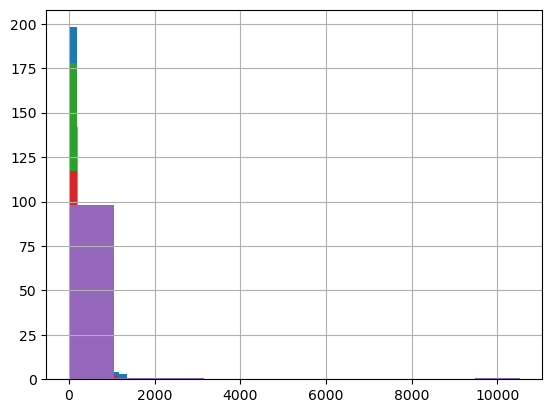

In [43]:
dataset.groupby('month')['duration'].hist();

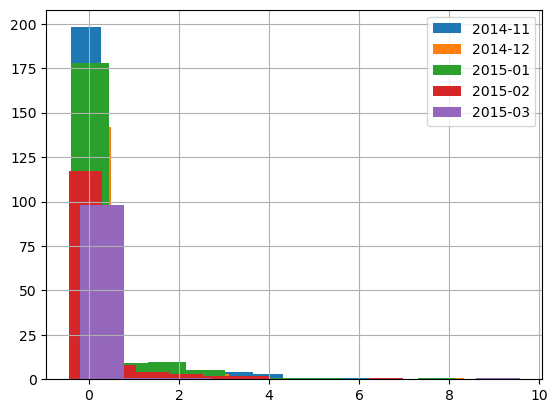

In [44]:
dataset.groupby('month')['norm_duration'].hist(legend=True);

## Pivot_table

In [45]:
dataset.pivot_table(values='duration', index='month', columns='key_bin', aggfunc='max')

key_bin,D0,D1
month,,
2014-11,101.0,1940.0
2014-12,114.0,2120.0
2015-01,106.0,1859.0
2015-02,104.0,1863.0
2015-03,107.0,10528.0


Los argumentos del método `pivot_table` son: 
-  el campo sobre el que vamos a calcular la función de agregación, en este caso $mean$.
-  index define la columna del `DataFrame` original cuyos valores sirven de índice de la tabla dinámica.
-  `columns` define la columna del `DataFrame` original cuyos valores sirven de columnas de la tabla dinámica


Podemos agregar los totales con el parámetro `margins=True`

In [ ]:
dataset.pivot_table('duration', index=['month', 'network'], columns='key_bin',\
                    margins=True, margins_name= 'totales')

En las siguientes clases seguiremos profundizando los conceptos de analisis de datos con Pandas, realizando combinaciones con distintos datasets, aplicando *joins*.

<!-- <span style="font-size:1.5em">Fin de la clase.</span> -->

<span style="font-size:2em">Muchas gracias por su atención!</span>